# Sampling

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
from functools import partial
import os

import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt

from optax import EmaState, EmptyState, ScaleByAdamState, ScaleByScheduleState

from diffuse.conditional import CondSDE
from diffuse.filter import generate_cond_sample
from diffuse.sde import SDE, SDEState, LinearSchedule
from diffuse.unet import UNet
from vraie_vie.create_dataset import WMH
from vraie_vie.utils import maskSpiral

jax.config.update("jax_enable_x64", False)

In [ ]:
config = {
    "modality": "FLAIR",
    "slice_size_template": 49,
    "begin_slice": 26,
    "flair_template_path": "/lustre/fswork/projects/rech/hlp/uha64uw/aistat24/WMH/MNI-FLAIR-2.0mm.nii.gz",
    "path_dataset": "/Users/geoffroyoudoumanessah/Documents/these/projects/datasets/WMH",
    # "path_dataset": "/lustre/fswork/projects/rech/hlp/uha64uw/aistat24/WMH",
    "save_path": "/lustre/fswork/projects/rech/hlp/uha64uw/aistat24/WMH/models/",
    "n_epochs": 4000,
    "batch_size": 1,
    "num_workers": 0,
    "n_t": 32,
    "tf": 2.0,
    "lr": 2e-4,
}

In [ ]:
# Retrieve trained Parameters

checkpoint = jnp.load(
    os.path.join(config["save_path"], "ann_1740.npz"), allow_pickle=True
)

params = checkpoint["params"].item()

ema_state = EmaState(count=checkpoint["ema_state"][0], ema=checkpoint["ema_state"][1])

opt_state = (
    EmptyState(),
    (
        ScaleByAdamState(
            count=checkpoint["opt_state_2"][0],
            mu=checkpoint["opt_state_2"][1],
            nu=checkpoint["opt_state_2"][2],
        ),
        ScaleByScheduleState(checkpoint["opt_state_3"][0]),
    ),
)

# Get the Datasets
wmh = WMH(config)
wmh.setup()
train_loader = wmh.get_train_dataloader().dataset

# Get the ScoreNet
nn_unet = UNet(config["tf"] / config["n_t"], 64, upsampling="pixel_shuffle")


def nn_score_(x, t, scoreNet, params):
    return scoreNet.apply(params, x, t)


nn_score = partial(nn_score_, scoreNet=nn_unet, params=params)

In [ ]:
n_steps = 1000
key = jax.random.PRNGKey(0)

ts = jnp.array([config["tf"]])
dts = jnp.array([2.0 / n_steps] * (n_steps))

beta = LinearSchedule(b_min=0.02, b_max=5.0, t0=0.0, T=2.0)
sde = SDE(beta=beta)

for _ in range(10):
    key, subkey = jax.random.split(key)
    init_samples = jax.random.normal(subkey, train_loader[0].shape)
    state_f = SDEState(position=init_samples, t=ts)

    revert_sde = partial(sde.reverso, score=nn_score, dts=dts)

    key, subkey = jax.random.split(key)
    state_0, state_Ts = revert_sde(subkey, state_f)

    plt.imshow(state_Ts.position[-1][..., 0], cmap="gray")
    plt.show()

In [ ]:
# On bruite
key = jax.random.PRNGKey(0)

x0_samples = jnp.array([train_loader[k] for k in range(config["batch_size"])])
n_x0 = x0_samples.shape[0]

key, subkey = jax.random.split(key)
ts = jax.random.uniform(key, (config["n_t"] - 1, 1), minval=1e-5, maxval=config["tf"])
ts = jnp.concatenate([ts, jnp.array([[config["tf"]]])], axis=0)

state_0 = SDEState(x0_samples, jnp.zeros((n_x0, 1)))
keys_x = jax.random.split(key, n_x0)
state = jax.vmap(sde.path, in_axes=(0, 0, 0))(keys_x, state_0, ts)

# On sample
n_steps = 1000

ts = jnp.array([config["tf"]])
dts = jnp.array([2.0 / n_steps] * (n_steps))

beta = LinearSchedule(b_min=0.02, b_max=5.0, t0=0.0, T=2.0)
sde = SDE(beta=beta)

key, subkey = jax.random.split(key)
init_samples = state.position[30]
state_f = SDEState(position=init_samples, t=ts)

revert_sde = partial(sde.reverso, score=nn_score, dts=dts)

key, subkey = jax.random.split(key)
state_0, state_Ts = revert_sde(subkey, state_f)

In [ ]:
plt.subplot(1, 2, 1)
plt.imshow(x0_samples[30][..., 0], cmap="gray")

plt.subplot(1, 2, 2)
plt.imshow(state_Ts.position[-1][..., 0], cmap="gray")
plt.show()

# Inverse problem

In [ ]:
# Get the Datasets
wmh = WMH(config)
wmh.setup()
train_loader = wmh.get_train_dataloader().dataset

key = jax.random.PRNGKey(0)

x = train_loader[0][..., 0].numpy()

key, subkey = jax.random.split(key)
w = jax.random.randint(subkey, shape=x.shape, minval=1, maxval=301)
s = 2000

mask = generate_mask(key, w, s)

fourier_transform_x = slice_fourier(x)
y = mask * fourier_transform_x

reconstructed_x = slice_inverse_fourier(y)

fig, axs = plt.subplots(1, 4, figsize=(20, 5))
axs[0].imshow(x, cmap="gray")
axs[0].set_title("Original x")
axs[1].imshow(
    jnp.abs(fourier_transform_x),
    cmap="gray",
    vmin=0,
    vmax=jnp.percentile(jnp.abs(fourier_transform_x), 99),
)
axs[1].set_title("Fourier Transform of x")
axs[2].imshow(jnp.abs(y), cmap="gray", vmin=0, vmax=jnp.percentile(jnp.abs(y), 99))
axs[2].set_title("y (Masked Fourier Transform)")
axs[3].imshow(jnp.abs(slice_inverse_fourier(y)), cmap="gray")
axs[3].set_title("Inverse Fourier of y")
plt.tight_layout()
plt.show()

# Conditional

In [ ]:
# Load dataset
wmh = WMH(config)
wmh.setup()
train_loader = wmh.get_train_dataloader()  # .dataset

key = jax.random.PRNGKey(0)
beta = LinearSchedule(b_min=0.02, b_max=5.0, t0=0.0, T=2.0)

checkpoint = jnp.load(
    os.path.join(config["save_path"], "ann_3355.npz"), allow_pickle=True
)


nn_unet = UNet(config["tf"] / config["n_t"], 64, upsampling="pixel_shuffle")
params = checkpoint["params"].item()


def nn_score_(x, t, scoreNet, params):
    return scoreNet.apply(params, x, t)


nn_score = partial(nn_score_, scoreNet=nn_unet, params=params)

sde = SDE(beta=beta)

s = 2000

for x in train_loader:
    break

plt.imshow(x[0, ..., 0], cmap="gray")

In [ ]:
size = (92, 112)

# mask_fourier = maskFourier(s=2000, img_shape=size)

mask_fourier = maskSpiral(
    img_shape=(92, 112), num_spiral=1, num_samples=5000, k_max=1.0, sigma=0.2
)
cond_sde = CondSDE(beta=beta, mask=mask_fourier, tf=2.0, score=nn_score)

fov = 1.0
y = mask_fourier.measure(fov, x[0])


res = generate_cond_sample(y, fov, key, cond_sde, x.shape[1:], 300, 200)

In [ ]:
from vraie_vie.utils import slice_inverse_fourier

x_sub = slice_inverse_fourier(y[..., 0])

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(20, 10))
axs[0, 0].imshow(x[0, ..., 0], cmap="gray")
axs[0, 0].set_title("Original Image")


mask = mask_fourier.make(fov)
axs[0, 1].imshow(mask, cmap="gray")
axs[0, 1].set_title("Fourier Mask")


axs[0, 2].imshow(res[0][0][0][..., 0], cmap="gray")
axs[0, 2].set_title("Reconstructed Image")


axs[1, 0].imshow(x[0, ..., 1], cmap="gray")
axs[1, 0].set_title("Original Anomaly Map")


axs[1, 1].imshow(x_sub, cmap="gray")
axs[1, 1].set_title("Subsampled reconstruction")

axs[1, 2].imshow(res[0][0][0][..., 1], cmap="gray")
axs[1, 2].set_title("Reconstructed Anomaly Map")

plt.tight_layout()
plt.show()

# Design

/linkhome/rech/genini01/uha64uw/.conda/envs/aoas/lib/python3.11/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=complex64 to dtype=float32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(
/linkhome/rech/genini01/uha64uw/.conda/envs/aoas/lib/python3.11/site-packages/jax/_src/ops/scatter.py:136: ComplexWarning: Casting complex values to real discards the imaginary part
  return lax_internal._convert_element_type(out, dtype, weak_type)


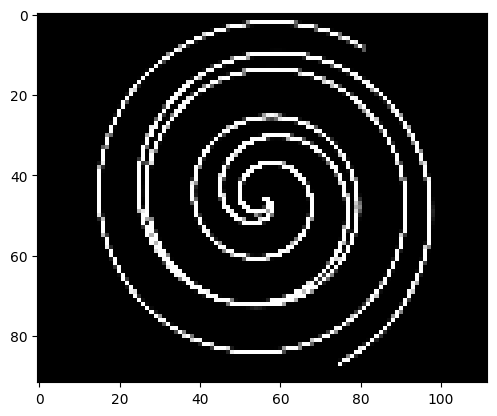

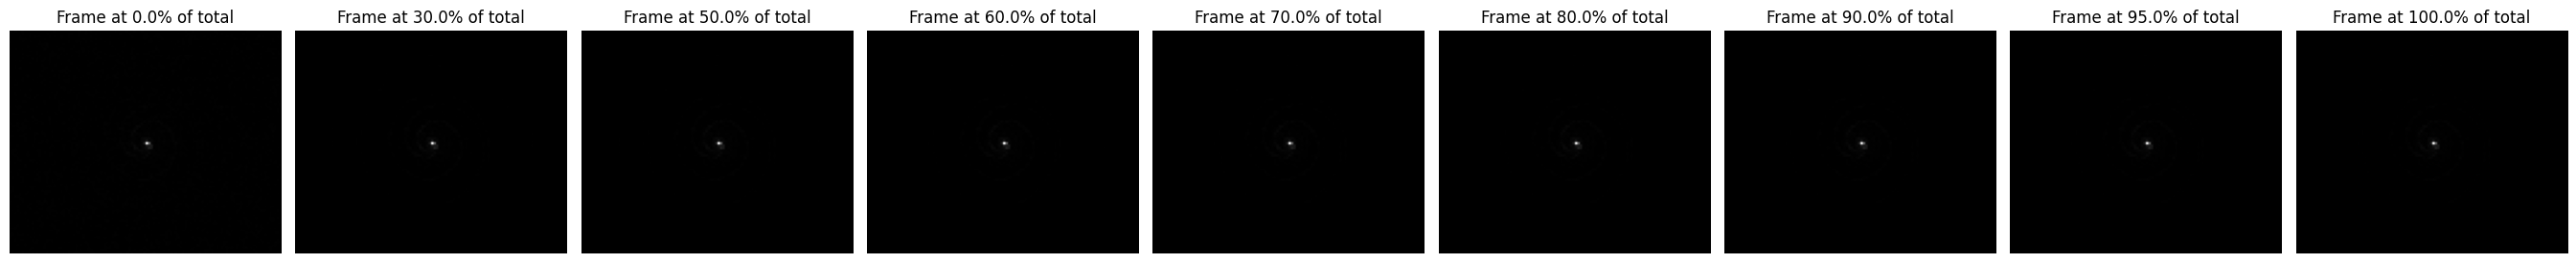

  0%|          | 0/299 [00:00<?, ?it/s]

In [ ]:
from vraie_vie.design_wmh import main
rng_key = key = jax.random.PRNGKey(0)
state = main(rng_key)